## DATA 
Getting Data from the keras datasets

In [8]:
from keras.datasets import reuters

NUM_WORDS=10000
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=NUM_WORDS)

Using TensorFlow backend.


### Data Insights
1. \# of training examples

In [9]:
print("Train Data Len\n",len(train_data))
print("Test Data Len\n", len(test_data))

Train Data Len
 8982
Test Data Len
 2246


## Explore train data......

#### 1. Sample train data

In [10]:
 train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

Thus training data is a set of indices of the words from word dictionary. We need to get actual data of sentences to work with Logistic Regression analysis. 

#### Sample Test Data

In [11]:
 train_labels[0:10]

array([ 3,  4,  3,  4,  4,  4,  4,  3,  3, 16])

##### Recovering original data by reverse dictionary look up!

In [13]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])


def get_original_data(data):
  orig_data = []

  for i in range(0, len(data)):
    orig_data.append( ' '.join([reverse_word_index.get(i - 3, '?') for i in data[i]]) )
  
  return orig_data

X_train_orig = get_original_data(train_data)
X_test_orig = get_original_data(test_data)

557056/550378 [==============================] - 0s 1us/step


#### Sample Orignal Data

In [14]:
X_train_orig[0:5]

['? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3',
 '? generale de banque sa lt ? br and lt heller overseas corp of chicago have each taken 50 pct stakes in ? company sa ? factors generale de banque said in a statement it gave no financial details of the transaction sa ? ? turnover in 1986 was 17 5 billion belgian francs reuter 3',
 '? shr 3 28 dlrs vs 22 cts shr diluted 2 99 dlrs vs 22 cts net 46 0 mln vs 3 328 000 avg shrs 14 0 mln vs 15 2 mln year shr 5 41 dlrs vs 1 56 dlrs shr diluted 4 94 dlrs vs 1 50 dlrs net 78 2 mln vs 25 9 mln avg shrs 14 5 mln vs 15 1 mln note earnings per share reflect the two for one split effective january 6 1987 per sh

Before building the bag of words model, we will examine the distribution of training labales. This will give us insights into 

How **balanced** the data is?

In [15]:
import numpy as np
from sklearn.utils import class_weight   # Using class weights function of sklearn to explore data 

class_weights = class_weight.compute_class_weight('balanced', np.unique(train_labels), train_labels)
class_weights

array([ 3.55019763,  0.45199275,  2.6386604 ,  0.06181097,  0.10018516,
       11.4859335 ,  4.06793478, 12.20380435,  1.40475446,  1.93327594,
        1.57468443,  0.5006689 ,  3.98491571,  1.13523761,  7.51003344,
        9.76304348,  0.43977673,  5.00668896,  2.95849802,  0.35566643,
        0.72587684,  1.9526087 , 13.0173913 ,  4.76246023,  3.14936886,
        2.12240076,  8.13586957, 13.0173913 ,  4.06793478, 10.27688787,
        4.33913043,  5.00668896,  6.10190217, 17.75098814,  3.90521739,
       19.52608696,  3.98491571, 10.27688787, 10.27688787,  8.13586957,
        5.42391304,  6.50869565, 15.02006689,  9.29813665, 16.27173913,
       10.84782609])

#### Explore class distribution 
Ploting class distribution as a bar graph

<BarContainer object of 46 artists>

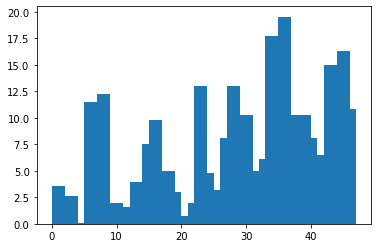

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.bar([i  for i in range(1, len(class_weights)+1)], class_weights, 2)

Clearly the data is **imbalanced**. We will have to mitigate this while training, one way of mitigating this is by using balanced class weights flag in Training algo.


#### Feature Extraction
We use couple of pre-processing technigues and tokenization to create a BOW model consisting of n-grams as features.
 
1. Count Vectorization: This is used to count the frequency of words occuring per documents.
2. Tf-Idf Vectorization : To mitigate effects of frequently occuring words/features we use Tf-Idf vectorization.
3. Stop Words removal: Some common words such as 'a', 'the' etc may not be useful and can be removed from the text. 
4. Text cases: We try with lower casing of all words to prevent dupliacte words with different casing.
5. N grams: We try using uni-gram, bi-gram and tri-grams.


In [17]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression

def get_pipeline(clf=LogisticRegression()):
  return Pipeline([
          ('vect', CountVectorizer()),
          ('tfidf', TfidfTransformer()),
          ('clf', clf)])

prep_processing_params={
    'vect__max_features': (5000, 10000, 30000,),
    'vect__ngram_range': ((1, 3),),
    'vect__lowercase': (True, False),
    'vect__stop_words': (None, 'english'),
    #'vect__tokenizer': (StemTokenizer()),
    ## 'vect__analyzer': ('word', 'char'),
    'tfidf__norm': (['l2'])
} 

## Algorithm: Logistic Regression
We experiment with logistic regression. We will tune following parameters of Logistic Regression.

__Logistic Regression Hyper-paramters__
1. **Regularization**: This is the most important parameter that we use to control Over-Fitting. (Here, we have conducted some adhoc experimentation with C before finalising the given range.)
2. **Class Weights**: This is used to mitigate the effect of **unbalanced classes**. We will try with both using balanced weights and non-balanced weights.
3. We also experiment with max-iterations, multi_class and solver (multi_class: 'auto', 'ovr' Since, this is a multi-class prediction problem, we try with 'One-vs-Rest' strategy and 'Multinomial' loss.)

In [18]:
lr_hyper_params={
    'clf__C': ([  0.001, 0.1]),
    'clf__class_weight': (['balanced', None]),  # This is to counteract unbalanced classes
    'clf__max_iter': ([200, 400]),
    'clf__multi_class': ([ 'auto']),
    'clf__solver': ([ 'liblinear', 'newton-cg' ]), #''
}

#### create pipeline with GridSearchCV

In [19]:
from sklearn.model_selection import GridSearchCV

parameters={}
parameters.update(prep_processing_params)
parameters.update(lr_hyper_params)

grid_search = GridSearchCV(get_pipeline(),
                           parameters,
                           cv=5,                    #KFold KFoldStratified
                           n_jobs=-1,
                           refit=True,
                           scoring='f1_weighted')

#### Train

In [5]:
from sklearn.externals import joblib

path = '/content/gdrive/My Drive/models/'
grid_search.fit(X_train_orig, train_labels)
#joblib.dump(grid_search.best_estimator_, path + 'LGR_all.pkl', compress = 1)

/Users/sushil/opt/anaconda3/envs/deeplearning/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


#### Best parameters

In [6]:
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best parameters set:
	clf__C: '1e-02'
	clf__class_weight: ‘Balanced’
	clf__max_iter: 400
	clf__multi_class: 'auto'
	clf__solver: 'liblinear'
	tfidf__norm: 'l2'
	vect__lowercase: True
	vect__max_features: 5000
	vect__ngram_range: (1, 3)
	vect__stop_words: 'english'


In [40]:
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

test_result_proba = grid_search.predict_proba(X_test_orig)
test_result = grid_search.predict(X_test_orig)

#auc = roc_auc_score(test_labels, test_result_proba[:, 1])
#print('Test ROC AUC: %.3f' % auc)

fscore = f1_score(test_labels, test_result, average='weighted')
print('F1 score %3f' % fscore)

matrix = confusion_matrix(test_labels, test_result)
print('Confusion Matrix', matrix)

print(test_result[0:10])
test_labels[0:10]

F1 score 0.816015
Confusion Matrix [[ 6  2  0 ...  0  0  0]
 [ 0 88  0 ...  0  0  0]
 [ 0  3 11 ...  0  0  0]
 ...
 [ 0  0  0 ...  2  0  0]
 [ 0  1  0 ...  0  4  0]
 [ 0  0  0 ...  0  0  1]]
[ 3 10  1  4 13  3  3  3  3  3]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


array([ 3, 10,  1,  4,  4,  3,  3,  3,  3,  3])

### Conclusion 
Logistic Regression yields an F1-score of 0.81, which is better than the other MLP classifer.*italicized text* 

## Algorithm: MLP Classifier
We experiment with Multi-Layer Perceptron Classifier. We will tune following parameters of MLP.

__MLP Hyper-paramters__
1. **Alpha**:  Alpha in the range of (0.0000005, 0.00002, 0.001, 0.01). It is the learning rate.
Among these 0.001 resulted in the best performance.
2. **Activation  Functions**: Applied following activation functions ('logistic', 'tanh', 'relu'). It is found that logistic function gave the best F1 score (precision and recall). Tanh, Relu (which is the default) actually decreased the accuracy.
3. **Layers**: Following hidden layer combinations are used ((50,), (50, 50), (100, ), (50, 50, 50))
A network with (50,) hidden neruons was found to give best results in terms of F1 score.

In [1]:
from sklearn.neural_network import MLPClassifier
pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', MLPClassifier()),
    ])

hyper_params={
    'clf__alpha': (0.0000005, 0.00002, 0.001, 0.01),
    'clf__hidden_layer_sizes': ((50,), (50, 50), (100, ), (50, 50, 50)),
    'clf__max_iter': (200, 400),
    'clf__batch_size': (200,),
    'clf__activation': (['logistic', 'tanh', 'relu'])
}

parameters={}
parameters.update(hyper_params)
parameters.update(prep_processing_params)

grid_search = GridSearchCV(pipeline,
                           parameters,
                           cv=5,                    #KFold KFoldStratified
                           n_jobs=-1,
                           refit=True,
                           scoring='f1_weighted')

grid_search.fit(X_train_orig, train_labels)

Best parameters set:
	clf__alpha: '1e-02'
	clf__hidden_layer_sizes: (50,)
	clf__max_iter: 200
	clf__batch_size: 200
	clf__activation: 'logistic'
	tfidf__norm: 'l2'
	vect__max_features: 10000
	vect__ngram_range: (1, 3)
	vect__lowercase': 'True'
	vect__tokenizer: <stemmer.StemTokenizer object at 0x126a2a898>
	vect__analyzer: 'char'


### Testing models against test data

In [0]:
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

test_result_proba = grid_search.predict_proba(X_test_orig)
test_result = grid_search.predict(X_test_orig)

#auc = roc_auc_score(test_labels, test_result_proba[:, 1])
#print('Test ROC AUC: %.3f' % auc)

fscore = f1_score(test_labels, test_result, average='weighted')
print('F1 score %3f' % fscore)

matrix = confusion_matrix(test_labels, test_result)
print('Confusion Matrix', matrix)



F1 score 0.7240712
Confusion Matrix [[ 9 0  0 ...  0  0  0]
 [ 0  19  0 ...  0  0  0]
 [ 0  23 4 ...  0  0  0]
 ...
 [ 0  0  0 ...  5  0  0]
 [ 0  1  0 ...  0  7  0]
 [ 0  0  0 ...  0  0  8]]


### Conclusion 
MLP Classification yields an F1-score of 0.72, which is not as good as the Logistic Regression. Hence, Logistic Regression performs better in this case.